# Semi-discrete optimal transport and application to computational fluid dynamics

## Semi-discrete optimal transport

### Presentation of the toolbox

$\newcommand{\Lag}{\mathrm{Lag}}
\newcommand{\Ker}{\mathrm{Ker}}
\newcommand{\abs}[1]{\left| #1 \right|}
\newcommand{\sca}[2]{\langle#1|#2\rangle}
\newcommand{\Class}{\mathcal{C}}
\newcommand{\Wass}{\mathrm{W}}
\newcommand{\D}{\mathrm{D}}
\newcommand{\B}{\mathrm{B}}
\newcommand{\one}{\textbf{1}}
\newcommand{\hdots}{\dots}
\newcommand{\dd}{\mathrm{d}}
\newcommand{\Rsp}{\mathbb{R}}
\newcommand{\eps}{\varepsilon}
\newcommand{\nr}[1]{\|#1\|}
$
We study here the optimal transport problem between a density
$\rho$ supported on a convex domain $\Omega$ of $\Rsp^2$ and a finitely supported
measure $\nu = \sum_{i\in I} \nu_i\delta_{y_i}$, where $I =
\{1,\hdots,N\}$. This problem can be recast as finding a Kantorovich
potential (a vector $\psi\in \Rsp^N$) satisfying the non-linear system
of equations

$$ \tag{P}\qquad \forall i\in I, G_i(\psi) = \nu_i, $$

where

$$
\begin{aligned}
  \label{eq:G}
  &G_i(\psi) = \rho(\Lag_i(\psi)) := \int_{\Lag_i(\psi)} \rho(x) \dd x,
  \\ &\Lag_i(\psi) = \{x \in \Omega\mid \forall j\in I, c(x,y_i) + \psi_i
  \leq c(x,y_j) + \psi_j \}.
\end{aligned}
$$

By default, we consider the cost $c(x,y) = \nr{x - y}^2$.  When we the set $Y$ is ambiguous, or
we want to consider another cost $c$, we will sometime use the heavier
notation $\Lag^c_i(y_1,\hdots,y_N;\psi_1,\hdots,\psi_N)$ for denoting
the $i$th Laguerre cell.  The set $\Lag_i(\psi) \subseteq P$ is called
the Laguerre cell of the $i$th point, and the collection
$(\Lag_i(\psi))_{1\leq i\leq N}$ is called the Laguerre
diagram.  We provide a simple wrapper around our code PySDOT to
easily perform computations on Laguerre diagrams (compute areas and
barycenters of Laguerre cells) when $\rho$ is constant. 

In [1]:
# imports
from pysdot.domain_types import ConvexPolyhedraAssembly
from pysdot import PowerDiagram
import numpy as np
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix


# constructs a square domain, to be passed to the laguerre_* functions
def make_square(box=[0,0,1,1]):
    domain = ConvexPolyhedraAssembly()
    domain.add_box([box[0], box[1]], [box[2], box[3]])
    return domain

# constructs a square domain, to be passed to the laguerre_* functions
def make_image(img,box=[0,0,1,1]):
    img = img / (box[2]-box[0])*(box[3]-box[1])*np.mean(img)
    domain = ConvexPolyhedraAssembly()
    domain.add_img([box[0], box[1]], [box[2], box[3]], img)
    return domain

# displays the Laguerre diagram
# optional arguments: disp_positions=True/False (display the points Y),
#                     disp_ids=True/False (show the number of each cell),
#                     disp_centroids=True/False (show the centroid of each cell)
#                     disp_arrows=True/False (display arrows beween points and centroids)
def laguerre_draw(domain, Y, psi, disp_ids=False, disp_positions=True, disp_centroids=False, 
                 disp_arrows=False):
    return PowerDiagram(Y, -psi, domain).display_jupyter(disp_ids=disp_ids,
                                                         disp_positions=disp_positions,
                                                         disp_centroids=disp_centroids,
                                                         disp_arrows=disp_arrows)

# computes the areas of the Laguerre cells intersected with the domain, and returns it as an array
# if der = True, also returns a sparse matrix representing the Jacobian of the areas with respect to psi
def laguerre_areas(domain, Y, psi, der=False):
    pd = PowerDiagram(Y, -psi, domain)
    if der:
        N = len(psi)
        mvs = pd.der_integrals_wrt_weights()
        if mvs.error:
            raise ValueError("une des cellules de Laguerre est vide")
        return mvs.v_values, csr_matrix((-mvs.m_values, mvs.m_columns, mvs.m_offsets), shape=(N,N))
    else:
        return pd.integrals()

# computes the centroid of the Laguerre cells intersected with the domain, and returns it as a Nx2 array
def laguerre_centroids(domain, Y, psi):
    return PowerDiagram(Y, -psi, domain).centroids()

### Numerical resolution of semi-discrete optimal transport

Equation (P) can be written as $G(\psi) = \nu$, where
$G(\psi) = (G_1(\psi),\hdots,G_N(\psi))\in\Rsp^N$ and where $ \nu =
(\nu_1,\hdots,\nu_N)\in\Rsp^N$.


**Q1.** The applet below allows to change the value of $\psi$ interactively. Try to solve the case $N=5$ by hand to get an understanding of what happens. 

In [2]:
# case N=5
from ipywidgets import interact, FloatSlider

N = 5
domain = make_square()
Y = np.array([[.15,.15],[.7,.2], [.4,.8], [.3,.5], [.7,.7]])
    
def disp(**kwargs):
    psi = np.array([p for p in kwargs.values()])
    print("areas=", laguerre_areas(domain, Y, psi))
    return laguerre_draw(domain, Y, psi, disp_positions=True, disp_ids=True, disp_centroids=False)
    
interact(disp, **{"psi%i"%i : FloatSlider(min=-.1,max=.1,step=0.0001,value=0.0) for i in range(N)});

interactive(children=(FloatSlider(value=0.0, description='psi0', max=0.1, min=-0.1, step=0.0001), FloatSlider(…

**Q2.** Start with $N \in \{5,10,20\}$ random points in the square $[0,\frac{1}{2}]^2$, $\Omega = [0,1]^2$, and $\nu = (\frac{1}{N},\hdots,\frac{1}{N})\in\Rsp^N$. Then try to use the function `scipy.optimize.fsolve`  to solve equation (P).

In [3]:
from scipy.optimize import fsolve

N = 10
np.random.seed(0)
domain = make_square()
Y = .5 * np.random.rand(N, 2)
nu = np.ones(N) / N
G = lambda psi: laguerre_areas(domain, Y, psi)

psi = fsolve(lambda psi: G(psi) - nu, np.zeros(N))
print(np.linalg.norm(G(psi) - nu))

4.3819540784381506e-16


**Q3.** Prove or check numerically that $G(\psi+e) = G(\psi)$, where $e =
(1,\hdots,1)\in\Rsp^N$ (the Laguerre cells are invariant by addition
  of a constant to each coordinates of $\psi$), and that $e \in \Ker
  \D G(\psi)$, so that $\D G(\psi)$ is never invertible.

In [4]:
N = 10
np.random.seed(0)
domain = make_square()
Y = .5 * np.random.rand(N, 2)
G = lambda psi: laguerre_areas(domain, Y, psi)
DG = lambda psi: laguerre_areas(domain, Y, psi, der=True)[1]

psi = .001 * np.random.rand(N)
e = np.ones(N)

print("|G(psi+e)-G(psi)| = %g" % np.linalg.norm(G(psi + e) - G(psi)))
print("|DG(psi)e| = %g" % np.linalg.norm(DG(psi) @ e))

print(np.linalg.eigh(DG(psi).todense())[0])

|G(psi+e)-G(psi)| = 1.59076e-15
|DG(psi)e| = 1.00199e-15
[-1.24244245e+01 -5.61081127e+00 -4.92208361e+00 -3.61635904e+00
 -3.02715766e+00 -2.14587482e+00 -1.51346918e+00 -1.01920972e+00
 -5.59544543e-01  1.14460034e-15]


We now turn to a much more efficient Newton's method for solving (P). Since $\D
G(\psi)$ is not invertible because of the invariance by addition of a
constant, we will fix $\psi_N = 0$. In practice, we simply remove the
last unknown ($\psi_N$) and also the last equation of the system
(which is then redundant, as $\sum_i G_i(\psi) = 1$), and define

$$\begin{aligned} F: \Rsp^{N-1} &\to \Rsp^{N-1}
  \\ \psi' = (\psi'_1,\hdots,\psi'_{N-1}) &\mapsto
  (G_1(\psi'_1,\hdots,\psi'_{N-1},0),\hdots,G_{N-1}(\psi'_1,\hdots,\psi'_{N-1},0)).
\end{aligned}
$$

The iterates in Newton's algorithm are denoted with an exponent,
${\psi'}^{(0)},\hdots,{\psi'}^{(k)}\in\Rsp^{N-1}$.  Linearizing the equation
$F({\psi'}^{(k)} + d^{(k)}) = \nu'$ (where $\nu' = (\nu_1,\hdots,\nu_{N-1})$, we get

\begin{equation} \tag{N}
  \begin{cases}
  \D F({\psi'}^{(k)})\cdot d^{(k)} = \nu' - F(\psi^{(k)}) \\
  {\psi'}^{(k+1)} = {\psi'}^{(k)} + d^{(k)}
\end{cases}
\end{equation}


**Q4.** Compute $\D F(\psi_1,\hdots,\psi_{N-1})$ explicitly and prove that if $\Ker \D
  G(\psi_1,\hdots,\psi_{N-1},0) = \Rsp e$, then $\D F(\psi_1,\hdots,\psi_{N-1})$ is
  invertible. Implement Newton's method for solving (P). Test
  it for $N \in \{10,100,1000\}$ random iid points in $[0,1]^2$, $P =
  [0,1]^2$ and $\nu = \frac{1}{N} e \in \Rsp^N$.

In [5]:
# use spsolve to solve the linear system

N = 10
np.random.seed(0)
domain = make_square()
Y = np.random.rand(N, 2)
nu = np.ones(N)/N
F = lambda psip: laguerre_areas(domain, Y, np.hstack((psip, 0)))[0:-1]
DF = lambda psip: laguerre_areas(domain, Y, np.hstack((psip, 0)), der=True)[1][0:-1, 0:-1]

psip = np.zeros(N-1)
nup = nu[0:-1]
it = 0

while True:
    display(laguerre_draw(domain, Y, np.hstack((psip, 0))))
    print("it=%d: |F - nu| = %g" % (it, np.linalg.norm(F(psip) - nup)))
    it += 1
    if np.linalg.norm(nup - F(psip)) <= 1e-6:
        break
    d = spsolve(DF(psip), nup - F(psip))
    psip = psip + d

<IPython.core.display.Javascript object>

it=0: |F - nu| = 0.141578


<IPython.core.display.Javascript object>

it=1: |F - nu| = 0.0415823


<IPython.core.display.Javascript object>

it=2: |F - nu| = 0.00180793


<IPython.core.display.Javascript object>

it=3: |F - nu| = 7.15388e-06


<IPython.core.display.Javascript object>

it=4: |F - nu| = 9.7525e-11


A sufficient condition for the invertibility of $\D F(\psi')$ is that $\psi'\in \mathcal{K}$ where

$$\mathcal{K} = \{ \psi'\in\Rsp^{N-1} \mid \forall i
\in\{1,\hdots, N-1\}, \quad F_i(\psi')  > 0 \}.
$$

In practice, this condition is ensured throught a simple
backtracking procedure: one takes ${\psi'}^{(k+1)} = {\psi'}^{(k)} +
t^{(k)} d^{(k)}$ where $t^{(k)} \in (0,1]$ is chosen small enough so
  that ${\psi'}^{(k+1)} \in \mathcal{K}$. This procedure is
  implemented in the function `optimal_transport(P,Y,nu,psi0)` provided below. The last 
  parameter `psi0`$\in \Rsp^N$ is optional, default to $0\in \Rsp^N$, and should be chosen so that
  
  \begin{equation} \label{eq:adm-psi0}
    \forall i\in I, G_i(\psi^{(0)}) > 0.
  \end{equation}  

In [6]:
def optimal_transport(domain, Y, nu, psi0=None, verbose=False, maxerr=1e-6, maxiter=10):
    if psi0 is None:
        psi0 = np.zeros(len(nu))
        
    def F(psip):
        g,h = laguerre_areas(domain, Y, np.hstack((psip,0)), der=True)
        return g[0:-1], h[0:-1,0:-1]
    
    psip = psi0[0:-1] - psi0[-1]
    nup = nu[0:-1]
    g,h = F(psip)
    for it in range(maxiter):
        err = np.linalg.norm(nup - g)
        if verbose:
            print("it %d: |err| = %g" % (it, err))
        if err <= maxerr:
            break
        d = spsolve(h, nup - g)
        t = 1.
        psip0 = psip.copy()
        while True:
            psip = psip0 + t*d
            try:
                g,h = F(psip)
            except ValueError:
                t = t/2
            if np.min(g) > 0:
                break
            else:
                t = t/2
    return np.hstack((psip,0))

### Application to optimal quantization

In optimal quantization, one wishes to approximate a probability density $\rho$ over a domain $\Omega\subseteq \Rsp^d$ by a finitely supported measure of the form $\mu = \frac{1}{N} \sum_{1\leq i\leq N} \delta_{y_i}$ in an optimal way, i.e. so as to minimize the quantization energy 

$$ \mathcal{D}(y_1,\hdots,y_N) = N \Wass_2^2(\rho, \frac{1}{N} \sum_{1\leq i\leq N} \delta_{y_i}) $$

As shown in the course 

$$ \nabla_{y_i} \mathcal{D}(y_1,\hdots,y_N) = b(y_1,\hdots,y_N) $$ 

where  $b_i(y_1,\hdots,y_N)$ is defined as follows:
- first, compute $\psi\in\Rsp^N$ the Kantorovich potential in
    the optimal transport problem between the $\rho$ on $\Omega$ and
    $\nu = \frac{1}{N}\sum_{i\in I} \delta_{y_i}$.
- $b_i(y_1,\hdots,y_N)$ is then the centroid of the Laguerre
    cell $\Lag_i(y_1,\hdots,y_N;\psi_1,\hdots,\psi_N)$ weighted by the density $\rho$.

**Q5.**  Write a function `B = ot_centroids(domain, Y)`, which takes as input
  a $N\times 2$ matrix $Y$ whose rows are the points $y_1,\hdots,y_N$
  and returns a $N\times 2$ matrix whose rows are
  $(b_i(y_1,\hdots,y_N))_{1\leq i\leq N}$. Observe its result when
  - $\Omega = [-\frac{1}{2},\frac{1}{2}]$
  - $y_1,\hdots,y_N$ are random iid in $\Omega$ (or $\frac{1}{2}\Omega$)
  - $\rho = \one_{\Omega}$

In [7]:
def ot_centroids(domain, Y):
    N = Y.shape[0]
    psi = optimal_transport(domain, Y, np.ones(N)/N, verbose=False)
    return laguerre_centroids(domain, Y, psi)

In [12]:
N = 100
domain = make_square([-.5,-.5,.5,.5])
nu = np.ones(N)/N

Y = -.5+np.random.rand(N, 2)
psi = optimal_transport(domain, Y, nu, verbose=False)
display(laguerre_draw(domain, Y, psi, disp_arrows=True, disp_centroids=True))

Y = -.5 + .5*np.random.rand(N, 2)
psi = optimal_transport(domain, Y, nu)
display(laguerre_draw(domain, Y, psi, disp_arrows=True, disp_centroids=True))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
import matplotlib.pyplot as plt
%matplotlib notebook

def show_quantization(domain, Y, tau=.1, niter=100):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    display = ax.scatter(Y[:,0], Y[:,1], c=Y[:,0])
    ax.axis('equal')
    fig.show()
    fig.canvas.draw()
    ax.axis([-.1, 1.1, -.1, 1.1])

    for i in range(niter):
        B = ot_centroids(domain, Y)
        Y = Y + tau*(B-Y)
        display.set_offsets(Y)
        fig.canvas.draw()
        fig.canvas.flush_events()
    
    return Y

A simple algorithm for optimal quantization consists in performing gradient descent on $\mathcal{D}$, e.g. 

$$ \begin{cases} Y^{(0)} \in \Rsp^{2 N} \\
Y^{(k+1)} = Y^(k) - \tau \nabla \mathcal{D}(Y)
\end{cases} $$

**Q6.** Implement this algorithm with $\rho = \one_{\Omega}$ and $\rho = \frac{1}{Z}\exp(-2 \nr{\cdot}^2) \one_{\Omega}$, where $\Omega = [-\frac{1}{2},\frac{1}{2}]$ and $Z$ is a normalizing constant
(NB: one can implement a non-constant density by using the function `make_image(img,box)`, which constructs a piecewise constant probability density from an image and a bounding box.) 

Check the formation of hexagonal patterns (as predicted by a theorem of L. Fejes Toth), by displaying the Laguerre diagram after the last iteration.

<IPython.core.display.Javascript object>


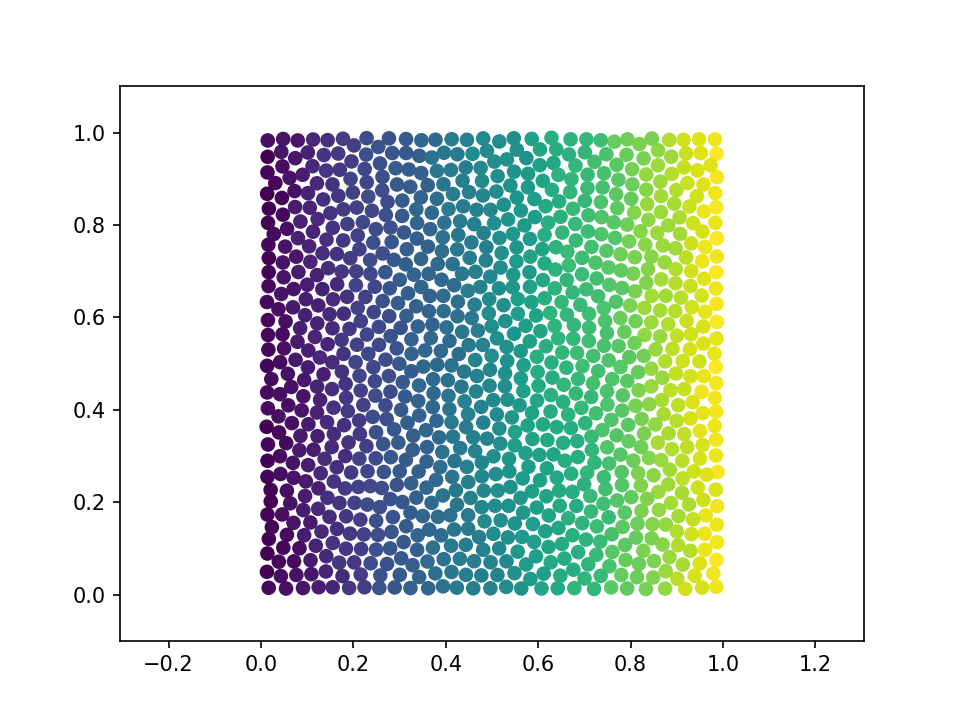

<IPython.core.display.Javascript object>

In [14]:
N = 1000
domain = make_square()
Y = show_quantization(domain, np.random.rand(N,2))
psi = optimal_transport(domain, Y, np.ones(N)/N)
laguerre_draw(domain, Y, psi)

<IPython.core.display.Javascript object>


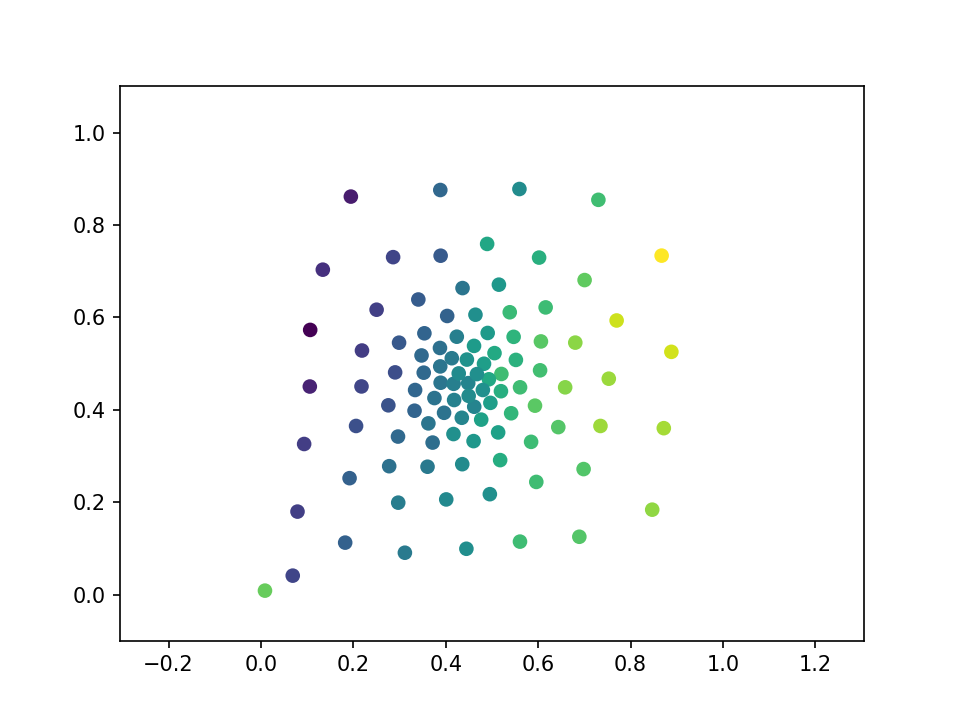

<IPython.core.display.Javascript object>

In [20]:
N = 100
n = 15
t = np.linspace(-1,1,n)
x, y = np.meshgrid(t,t)
img = np.exp(-2*(x**2 + y**2))
domain = make_image(img, box=[0,0,1,1])
np.random.rand(0)
Y = show_quantization(domain, .2 + .6 * np.random.randn(N, 2), tau=.2)
psi = optimal_transport(domain, Y, np.ones(N) / N)
laguerre_draw(domain, Y, psi)

### Application to  Euler's equations for incompressible fluids

Given a domain $\Omega \subseteq \Rsp^2$, an initial velocity field $u_0:
\Omega\to\Rsp$ and an initial configuration of points $Y(0) =
(y_1(0),\hdots,y_N(0))\in\Rsp^d$, we consider the following system of
ODE as an approximation of Euler's equations for incompressible
fluids, where $b_i$ is defined above:

\begin{equation}  \tag{Euler}
  \begin{cases}
    \ddot{y}_i(t) = \frac{1}{\eps} (b_i(y_1(t),\hdots,y_N(t)) - y_i(t)) \\
    \dot{y}_i(0) = u_0(Y_i(t)) \\
  \end{cases}
\end{equation}



**Q7.** Implement the symplectic Euler scheme to solve the ODE (Euler):

  $$ \begin{cases}
    u_i^{(n+1)} = u_i^{(n)} + \frac{\tau}{\eps^2}(b_i(y_1,\hdots,y_n) - y_i)\\
    y_i^{(n+1)} = y_i^{(n)} + \tau u_i^{(n+1)} \\  
    [y_1^{(0)},\hdots,y_N^{(0)}] = \texttt{barycenters(rand(N,2)-.5)} \\
    v_i^{(0)} = u_0(y_i^{(0)}). 
  \end{cases}
  $$
  
  As it can be quite tricky to select the parameters, we suggest: 
  - $\Omega = [-\frac{1}{2}, \frac{1}{2}]^2$, 
  - $N=400$, $\eps = 0.05$, $\tau = 0.01$
  - $u_0(y_1,y_2) = (-\cos(\pi y_1) \sin(\pi y_2), \sin(\pi y_1) \cos(\pi y_2)).$

In [ ]:
import matplotlib.pyplot as plt
%matplotlib notebook

N = 400
domain = make_square([-.5,-.5,.5,.5])

def optimal_quantization(domain, Y0, tau=.5, niter=5):
    Y = ot_centroids(domain, Y0)
    for i in range(niter):
        Y = Y + tau*(ot_centroids(domain, Y)-Y)
    return Y

Y = optimal_quantization(domain, -.5+np.random.rand(N, 2))
U = np.zeros_like(Y)
U[:,0] = -np.cos(np.pi*Y[:,0])*np.sin(np.pi*Y[:,1])
U[:,1] = np.sin(np.pi*Y[:,0])*np.cos(np.pi*Y[:,1])
tau = 0.002
eps = 0.05

fig = plt.figure()
ax = fig.add_subplot(111)
display = ax.scatter(Y[:,0], Y[:,1], c=Y[:,0])
ax.axis('equal')
fig.show()
fig.canvas.draw()

# Symplectic Euler
for i in range(200):
    B = ot_centroids(domain, Y)
    U = U + tau/eps**2 * (B-Y)
    Y = Y + tau*U
    display.set_offsets(Y)
    fig.canvas.draw()
    fig.canvas.flush_events()

### Velocity Verlet
# Yold = Y.copy()
# Y = Y + tau*U
# for i in range(500):
#     B = barycenters(domain, Y)
#     A = 1/eps**2 * (B-Y)
#     Ynew = 2*Y - Yold + tau*tau*A
#     Yold = Y.copy()
#     Y = Ynew
#     display.set_offsets(Y)
#     fig.canvas.draw()
#     fig.canvas.flush_events()

## Partial optimal transport and crowd motion
### Partial optimal transport 

As before, we assume that $\rho$ is a density on a domain
$\Omega\subseteq \Rsp^2$ and $\nu = \frac{\alpha}{N}\sum_{i\in
  I}\delta_{y_i}$. However, in \emph{partial optimal transport}, one
assumes that the total mass of $\nu$ is strictly less than the mass of
$\rho$, i.e. $\alpha < \rho(P)$. The effect of the constant $\alpha$
is displayed in Figure~\ref{fig:partial}. It is possible to turn
partial optimal transport into classical optimal transport as follows:
- introduce a fictive point $y_{\infty}$ which will receive the
    left-over mass. Set $\widetilde{I} = I \cup \{+\infty\} =
    \{1,\hdots,N,+\infty\}$ and $\widetilde{\nu} = \alpha
    \delta_{y_\infty} + \nu$ ;
- introduce a modified cost $\widetilde{c}(x,y_i) = \nr{x -
    y_i}^2$ if $i\in I$ and $c(x,y_\infty) = 0$. 
    
With this cost, it is free to move mass to the fictive point $y_\infty$.
Then, as in classical optimal transport, one wishes to solve the
non-linear system

$$\forall i\in I, \widetilde{G}_i(\widetilde{\psi}) =
\nu_i$$

where 
- $\widetilde{\psi} = (\psi_1,\hdots,\psi_N,\psi_\infty)
\in \Rsp^{N+1}$, 
- $\widetilde{G}_i(\widetilde{\psi}) =
\mathrm{area}(\widetilde{\Lag}_i(\psi))$ and 
$$\begin{align*}
  \widetilde{\Lag}_i(\psi_1,\hdots,\psi_N,\psi_\infty) &=
  \Lag_i^{\tilde{c}}(y_1,\hdots,y_N,y_\infty,\psi_1,\hdots,\psi_N,0)
  \\ &=\{ x\in P \mid \forall j\in \widetilde{I}, \widetilde{c}(x,y_i)
  + \psi_j \leq \widetilde{c}(x,y_j) + \psi_j\}
\end{align*}$$

**Q8.** Check that for all $i\in I$, 
  $\widetilde{\Lag}_i(\widetilde{\psi}) = \Lag_i(y_1,\hdots,y_N;\psi)
  \cap \B(y_i, \sqrt{\psi_\infty-\psi_i}), $ where $\Lag_i(\psi)$ is
  the usual Laguerre cell (as defined in the first part) and $\B(y,r)$ is the ball centered at $y$ with radius $r$.
  
  
<table>
    <tbody>
        <tr>
            <td> <img src="figures/partial-0.jpg" width="100%" /> </td>
            <td> <img src="figures/partial-1.jpg" width="100%" /> </td>
            <td> <img src="figures/partial-2.jpg" width="100%" /> </td> 
            <td> <img src="figures/partial-3.jpg" width="100%" /> </td>
        </tr>
    </tbody>
    <caption> Partial optimal transport between the measure $\nu =
    \frac{\alpha}{N} \sum_{1\leq i\leq N} \delta_{y_i}$ and $\rho =
    \one_{[-1,1]^2}$. The first figure displays the points $y_i$ and
    the next figures display the Laguerre cells obtained for $\alpha
    =1,2,3$ respectively. The Laguerre cells in multiple colors
    correspond the portion of the domain $[-1,1]^2$ that will be
        transported towards $\nu$. </caption>
</table>


**Q9.**


In [ ]:
from pysdot import OptimalTransport
from pysdot.radial_funcs import RadialFuncInBall

def partial_optimal_transport(domain, Y, nu, psi0 = None):
    ot = OptimalTransport(domain, RadialFuncInBall())
    if psi0 == None:
        psi = -np.sqrt(nu)
    else:
        psi = -psi0.copy()
    ot.set_positions(Y)
    ot.set_weights(-psi)
    ot.set_masses(nu)
    ot.adjust_weights()
    return ot

N = 100
domain = make_square([0,0,10,10])
Y = .8*np.random.rand(N,2)
nu = 1.5*np.ones(N)/N
ot = partial_optimal_transport(domain, Y, nu)
C = ot.get_centroids()

plt.figure()
plt.scatter(C[:,0],C[:,1])


**Q10**  Write a function \texttt{B=proj\_lebesgue\_partial(Y,Z)}, which
  takes as input a $N\times 2$ matrix $Y$ whose rows are the points
  $y_1,\hdots,y_N$ and a matrix $Z$ describing the points in the
  background. This function returns a $N\times 2$ matrix whose rows
  are $(c_i(y_1,\hdots,y_N))_{1\leq i\leq N}$. Observe the result of this function when
  $y_1,\hdots,y_N$ are random iid in the square $[-r,r]^2$ for
  $r=\{0.2, 0.5, 1.05\}$.


### Discretization of a crowd motion model

In this model, the crowd is described by a finite sum of Dirac masses
$\nu(t) = \frac{\alpha}{N}\sum_{1\leq i\leq N} \delta_{y_i}(t)$,
living in a domain $\Omega$ (the ``room'') with area strictly larger than $\alpha$. For
simplicity, we will assume that $\alpha = 1$. They
are subject to two forces: the first force is minus the gradient of a
potential $V$ (corresponding to the fact that they want, for instance
to go towards the exit of the room) and the second force corresponds
to congestion, and is enforced through partial optimal transport:

$$
\begin{equation}  \tag{Crowd} \label{eq:Crowd} 
    \dot{y}_i(t) = -\nabla V(y_i(t)) + \frac{1}{\eps} (c_i(y_1(t),\hdots,y_N(t)) - y_i(t)) \\
\end{equation}
$$

As before, $c_i(y_1(t),\hdots,y_N(t))$ is the barycenter of the $i$th
Laguerre cell in the partial transport between $\nu(t)$ and $\rho$. As
explained in the course, the sum
$$\frac{\alpha}{N} \sum_{i=1}^N
\nr{c_i(y_1(t),\hdots,y_N(t))-y_i(t)}^2 = \min_{\sigma \leq \rho,
  \sigma(P) = \alpha} \mathrm{W}_2^2(\nu(t),\sigma),$$ measures how
far the measure $\nu(t)$ is from satisfying the congestion constraint.


### Approximation of partial optimal transport

Computing the intersection between a ball and a convex polygon
efficiently is rather tedious, but we can resort to an
approximation. Let $Z \subseteq P$ be a finite subset which is
$\eta$-dense in the sense that $P\subseteq \cup_{z\in P} B(z,\eta)$.
We consider an approximation of the previous problem, denoted using
hats instead of tildes. We keep the point at infinity $\hat{I} =
I\cup\{+\infty\}$, $\hat{\nu} = \widetilde{\nu}$ but we set

$$ \hat{c}(x,y_i) = \begin{cases}
  \nr{x - y_i}^2 & \hbox{ if } i\in I\\
  \min_{z\in Z} \nr{z - x}^2 &\hbox{ if } i=+\infty
\end{cases}
$$

We define $\hat{G}_i(\hat{\psi}) = \rho(\hat{\Lag}_i(\psi))$ and
the Laguerre cell  $\hat{\Lag}_i$ accordingly:

$$ \hat{\Lag}_i(\hat{\psi}) = \{ x\in P \mid \forall j\in \hat{I}, \hat{c}(x,y_i) + \psi_j \leq \hat{c}(x,y_j) + \psi_j\}.$$

**Q9.** Prove that $\tilde{c}\leq \hat{c} \leq \tilde{c} + \eta^2$
  (explaining why the problem with $\hat{c}$ is an approximation of
  the problem with $\tilde{c}$). Prove that if $Z = \{z_1,\hdots,z_M\}$, then
  
  \begin{align*}
    \forall i\in\{1,\hdots,N\},~\hat{\Lag}_i(\psi) =
    \Lag_i(y_1,\hdots,y_N, z_1,\hdots,z_N;
    \psi_1,\hdots,\psi_N,\psi_\infty,\hdots,\psi_\infty),
  \end{align*}
  
where  $\psi_\infty$ is repeated $N$ times.
  
In other words, $\hat{\Lag}_i(\psi)$ turns out to be a usual Laguerre
cell, for the quadratic cost. The value of $\hat{G}_i(\psi) =
\rho(\hat{\Lag}_i(\psi))$ and its gradient with respect to $\psi$ can
therefore be easily computed using \texttt{laguerre\_areas}. We can
now adapt the backtracking Newton algorithm used in the function
`optimal_transport` to the (approximated) partial transport
setting, by setting

$$\begin{aligned} F: \Rsp^N&\to\Rsp^N \\
  (\psi_1,\hdots,\psi_N) &\mapsto (\hat{G}_i(\psi_i,\hdots,\psi_N, 0, \hdots, 0))_{1\leq i\leq N}
\end{aligned}
$$

where $0$ is repeated $N$ times. As in the first part, the matrix $\D F(\psi)$ will be invertible
provided that $\psi\in \mathcal{K}$, where

$$\mathcal{K} = \{ \psi\in\Rsp^{N} \mid \forall i
\in\{1,\hdots, N\},\quad F_i(\psi)  > 0 \}.
$$

**Q10.** Taking inspiration from `optimal_transport`, write a function for partial optimal transport: 
  `partial_transport(domain,Y,nu,Z)` where `domain`,Y,nu are as before
  (except that $\sum_i \nu_i$ is now strictly less than the area of
  the polygon $P$), and $Z$ is a $M\times 2$ matrix whose rows are the
  points in $Z$. Try it in the following setting $Z$ is a $M=20^2$
  uniform grid in $P = [-1,1]^2$, $Y$ is a random iid point cloud with
  cardinal $N=100$. One can display the result by showing the Laguerre
  cells with a color depending on whether they correspond to a point
  in $Y$ or $Z$.